In [1]:
mseed = 2
import numpy as np
np.random.seed(mseed)
import torch
torch.manual_seed(mseed)

import time
import h5py
import pickle

import matplotlib.pyplot as plt
import matplotlib as mpl

from torch import nn
import torch.nn.functional as F
import torcheval.metrics
from torch.utils.data import Dataset, DataLoader, random_split

import datetime as d
import copy
import os
import sys

masterdir = '/home/seismoai/data/forecasting/'
blockdir = masterdir + 'blockdata/'
modeldir = masterdir + 'models/'

/home/jkoehler/ENVS/forecasting_venv/lib/python3.8/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
if torch.cuda.is_available():
    print('Cuda Available')
else:
    print('No GPU support currently')

device = "cuda" if torch.cuda.is_available() else "cpu"

No GPU support currently


# 1. Autoencoder
## 1.1 Create Architecture

In [3]:
def makeAE_PT():
    class Autoencoder(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv0 = nn.Conv2d(in_channels= 1, out_channels=  4, kernel_size=4)
            self.conv1 = nn.Conv2d(in_channels= 4, out_channels=  8, kernel_size=4)
            self.conv2 = nn.Conv2d(in_channels= 8, out_channels= 16, kernel_size=4)
            self.conv3 = nn.Conv2d(in_channels=16, out_channels= 32, kernel_size=4)
            
            self.tconv3 = nn.ConvTranspose2d(in_channels=32,   out_channels= 16,  kernel_size=4)
            self.tconv2 = nn.ConvTranspose2d(in_channels=16,   out_channels=  8,  kernel_size=4)
            self.tconv1 = nn.ConvTranspose2d(in_channels= 8,   out_channels=  4,  kernel_size=4)
            self.tconv0 = nn.ConvTranspose2d(in_channels= 4,   out_channels=  1,  kernel_size=4)
            
            self.acti = nn.functional.relu

        def forward(self, x):
            y = self.acti(self.conv0(x.view(-1, 1, 32, 32)))
            x = self.acti(self.conv1(y))
            z = self.acti(self.conv2(x))
            x = self.acti(self.conv3(z))
            
            x = self.acti(self.tconv3(x))
            x = self.acti(self.tconv2(x+z))
            x = self.acti(self.tconv1(x))
            x = self.acti(self.tconv0(x+y))
            
            return self.acti(x).view(-1, 32, 32)
    
    return Autoencoder().to(device)

def getAE(filename):
    model_ae = makeAE_PT()
    model_ae.load_state_dict(torch.load(modeldir + filename))
    model_ae.eval()
    return model_ae

# 2 Dilated Recurrent Network 
## 2.1 Read Preprocessed Data

In [6]:
f2 = h5py.File(blockdir + 'Tiles_Parameters_0.1.hdf5', 'r')
bval_loc = np.array(f2['b_value_730_0.15'])[:, 150:260, 150:260]
n_eq_avg = np.array(f2['n_eq_730_0.15'])[:, 150:260, 150:260]
maxm_loc = np.array(f2['maxmag'])[:, 150:260, 150:260]
dept_avg = np.array(f2['depth'])[:, 150:260, 150:260]
noeqarray = np.array(f2['NoEQArray_d730_r0.15_m4.0'])[:, 150:228, 150:228] 
f2.close()

b_block = np.clip(np.nan_to_num(bval_loc, posinf=2, neginf=0),0,2)

In [32]:
def parallelSpecEqArr():
    t0 = time.time()
    lookback = 730
    dr = 0.15
    
    f2 = h5py.File(blockdir + 'Tiles_Parameters_0.1.hdf5', 'r')
    n_eq_avg = np.array(f2['n_eq_{:03d}_{:4.2f}'.format(lookback, dr)])
    maxm_loc = np.array(f2['maxmag'])
    f2.close()
    sel_ge5 = np.argwhere(maxm_loc[512:, 16:-16, 16:-16] >= 5.0)

    steps_to_zero = 5

    valarray = np.zeros(maxm_loc.shape-np.array([512, 32,32]))
    for t, x, y in sel_ge5:
        iarray = 1/np.arange(1, t+1)[::-1]
        _, xmax, ymax = maxm_loc[:, 16:-16, 16:-16].shape
        
        for iix, ix in enumerate(range(x-steps_to_zero, x+steps_to_zero+1)):
            if ix < 0 or ix >= xmax:
                continue
            for iiy, iy in enumerate(range(y-steps_to_zero, y+steps_to_zero+1)):
                if iy < 0 or iy >= ymax:
                    continue
                iixl = max(iix, 2*steps_to_zero-iix)-steps_to_zero
                iiyl = max(iiy, 2*steps_to_zero-iiy)-steps_to_zero
                iir = iixl + iiyl
                if iir > steps_to_zero:
                    continue
                    
                valarray[:t, ix, iy] = np.where(
                    valarray[:t, ix, iy] > iarray, 
                    valarray[:t, ix, iy], 
                    iarray/steps_to_zero *(steps_to_zero - iir)) 
    t1 = time.time()
    print(t1-t0)
    return valarray
    

In [148]:
def parallelSpecEqArr2():
    t0 = time.time()
    lookback = 730
    dr = 0.15
    
    f2 = h5py.File(blockdir + 'Tiles_Parameters_0.1.hdf5', 'r')
    n_eq_avg = np.array(f2['n_eq_{:03d}_{:4.2f}'.format(lookback, dr)])
    maxm_loc = np.array(f2['maxmag'])
    f2.close()
    sel_ge5 = np.argwhere(maxm_loc[512:, 16:-16, 16:-16] >= 5.0)

    steps_to_zero = 5

    valarray = np.zeros(maxm_loc.shape)
    for t, x, y in sel_ge5[::-1]:
        iarray = 1/np.arange(1, t+2)[::-1]
        _, xmax, ymax = maxm_loc[:, 16:-16, 16:-16].shape
        
        valarray[:t+1, x, y] = iarray
        for i in range(1, steps_to_zero):
            for j in range(-i, i+1):
                for k in range(-i, i+1):
                    if abs(j)+abs(k) == i:
                        valarray[:t+1, x+j, y+k] = np.maximum(valarray[:t+1, x+j, y+k], iarray * (steps_to_zero-i) * (1/steps_to_zero))
                        #valarray[:t+1, x+j, y+k] =  iarray * (steps_to_zero-i) * (1/steps_to_zero)

    t1 = time.time()
    print(t1-t0)
    return np.sqrt(valarray[:-512, :-32, :-32])
    

## 2.2 CDN Architecture

In [13]:
def makeCDN_PT():
    class CDBlock(nn.Module):
        def __init__(self, call, reduce, channels_in, channels_out):
            super(CDBlock, self).__init__()
            
            self.dilation = 2**(call-1)
            self.c_in = channels_in
            self.c_out = channels_out
            self.reduce = reduce
            
            self.conv3d_1 = nn.Conv3d(in_channels=self.c_in,  out_channels=self.c_out, kernel_size=(1,2,2), padding=0, stride=(1,2,2))
            self.conv3d_2 = nn.Conv3d(in_channels=self.c_out, out_channels=self.c_out, kernel_size=(2,1,1), padding='valid', dilation=(self.dilation,1,1))

            self.batch_norm = nn.BatchNorm3d(self.c_out)
            self.acti = nn.functional.leaky_relu
        
        def forward(self, x):
            if self.reduce:
                x = self.conv3d_1(x)
            x = self.conv3d_2(x)
            x = self.acti(self.batch_norm(x))
            return x

    class CDNModel(nn.Module):
        def __init__(self):
            super().__init__()
            self.linear = nn.Linear(in_features=32, out_features=1)
            self.sigmoid =  nn.functional.sigmoid

            self.blocks = nn.ModuleList([
                    CDBlock(1, True ,  1,  2).to(device) ,
                    CDBlock(2, False,  2,  2).to(device) ,
                    CDBlock(3, True ,  2,  4).to(device) ,
                    CDBlock(4, False,  4,  4).to(device) ,
                    CDBlock(5, True ,  4,  8).to(device) ,
                    CDBlock(6, False,  8,  8).to(device) ,
                    CDBlock(7, True ,  8, 16).to(device) ,
                    CDBlock(8, False, 16, 16).to(device) ,
                    CDBlock(9, True , 16, 32).to(device) ,
            ])                

        def forward(self, x):
            x = x[:, None, :,:,:]
            for i, block in enumerate(self.blocks):
                x = block(x)
            x = self.linear(x.view((-1, 32)))
            return torch.squeeze(self.sigmoid(x))
            
    return CDNModel().to(device)     

## 2.3 Datasets

In [14]:
def autoencode(data):
    in_shape = data.shape
    return  data - model_ae(data).view(in_shape)

class DatasetTrain(Dataset):
    def __init__(self, meta_epoch, inputlen=512, epochlen=30, minmag=5.0, lastlen=0, use_autoencoder=True):
        super(Dataset, self).__init__()

        tend = inputlen+(meta_epoch+1)*epochlen

        inxs1 = np.argwhere(maxm_loc[inputlen:tend, 16:-16, 16:-16] >= minmag) # target = 1
        lenEL = inxs1.shape[0]
        
        inxs0 = np.argwhere(noeqarray[:tend-inputlen])
        inxs0 = inxs0[np.random.choice(inxs0.shape[0], size=lenEL)]  
        
        data_train = np.append(
            np.array([b_block[inx[0]:inx[0]+inputlen, inx[1]:inx[1]+32, inx[2]:inx[2]+32] for inx in inxs1]),
            np.array([b_block[inx[0]:inx[0]+inputlen, inx[1]:inx[1]+32, inx[2]:inx[2]+32] for inx in inxs0]),
            axis=0
        )

        self.inxs_save = {'TP': inxs1, 'TN': inxs0}
        self.targets = torch.cat((torch.ones(lenEL), torch.zeros(lenEL))).to(bool)

        sample_weight = np.ones(self.targets.shape)
        if lastlen:
            sample_weight[lenEL-lastlen:lenEL]     = targets_train.shape[0]/(lastlen+1)
            sample_weight[2*lenEL-lastlen:2*lenEL] = targets_train.shape[0]/(lastlen+1)
            print('Weight factor: {}'.format(targets_train.shape[0]/(lastlen+1)))

        self.weight = torch.from_numpy(sample_weight)
        self.weight /= self.weight.max()

        data_train = torch.from_numpy(data_train).to(torch.float32).to(device)

        if use_autoencoder:
            self.data = autoencode(data_train)
        else:
            self.data = data_train

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        return self.data[index], self.targets[index], self.weight[index]

class DatasetValid(Dataset):
    def __init__(self, meta_epoch, inputlen=512, epochlen=30, minmag=5.0, lastlen=0, use_autoencoder=True):
        super(Dataset, self).__init__()
        
        tend = inputlen+(meta_epoch+1)*epochlen
        
        inxs1 = np.argwhere(maxm_loc[tend:tend+epochlen, 16:-16, 16:-16] >= minmag) # target = 1
        lenEL = inxs1.shape[0]
        
        if lenEL == 0:
            self.is_empty = True 
        else: 
            self.is_empty =  False
            self.lastlen = lenEL
            
            inxs0 = np.argwhere(noeqarray[tend-inputlen:tend-inputlen+epochlen])
            inxs0 = inxs0[np.random.choice(inxs0.shape[0], size=lenEL)]

            data_valid = np.append(
                np.array([b_block[inx[0]+tend-inputlen:inx[0]+tend, inx[1]:inx[1]+32, inx[2]:inx[2]+32] for inx in inxs1]),
                np.array([b_block[inx[0]+tend-inputlen:inx[0]+tend, inx[1]:inx[1]+32, inx[2]:inx[2]+32] for inx in inxs0]),
                axis=0
            )
                    
            self.inxs_save = {'VP': inxs1, 'VN': inxs0}

            data_valid = torch.from_numpy(data_valid).to(torch.float32).to(device)
            if use_autoencoder:
                self.data = autoencode(data_valid)
            else:
                self.data = data_valid
                
            self.targets = torch.cat((torch.ones(lenEL), torch.zeros(lenEL))).to(bool)
        
    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

## 2.4 Dataloader

In [15]:
def getDataloaders(meta_epoch, lastlen=False, inputlen=512, epochlen=30, minmag=5.0, use_autoencoder=True, batch_size=16):
    time0 = time.time()
    
    while True:
        validset = DatasetValid(meta_epoch, inputlen, epochlen, minmag, lastlen, use_autoencoder)
        if validset.is_empty:
            lastlen = False
            print('Meta Epoch {} contains no events >= {} M. Skipping!'.format(meta_epoch, minmag))
            meta_epoch += 1
            if inputlen+(meta_epoch+1)*epochlen > maxm_loc.shape[0]:
                print('inputlen+(meta_epoch+1)*epochlen > maxm_loc.shape[0]')
                print('Triggered in getDataloaders')
                print(inputlen, meta_epoch, epochlen, maxm_loc.shape[0])   
                return False
        else:
            lastlen_new = validset.lastlen
            meta_epoch += 1
            break
            
    
    trainset = DatasetTrain(meta_epoch-1, inputlen, epochlen, minmag, lastlen, use_autoencoder)
    lastlen = lastlen_new
    
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    validloader = DataLoader(validset, batch_size=batch_size, shuffle=False)
    
    time1 = time.time()
    print(f'ME:{meta_epoch-1:>3d}: | Batches ({len(trainloader):>4d}/{len(validloader):>4d}) samples: ({len(trainset):>4d}/{len(validset):>4d}) ', end='')

    return trainloader, validloader, (len(trainset), len(validset)), meta_epoch, lastlen

## 2.5 Define Training Functions
train_std: Normal training, to be executed on a model and on a dataset  
train_progressive: Progressive training, calls train_std

In [17]:
def train_std(model, meta_epoch, epochs, trainloader, validloader, setlens, lossfunction, optimizer, run_name, checkpoint_filepath_base):
    loss_train = []
    loss_valid = []
    earlystopping_counter = 0

    targets_list = []
    predict_list = []

    def reduce_loss(loss, weights=None):
        if type(weights) == type(None):
            return torch.mean(loss)
        else:
            return torch.mean(loss*weights)
    
    
    for e in range(epochs):
        time0 = time.time()
        train_loss = 0.0
        valid_loss = 0.0

        model.train()
        for data, targets, weights in trainloader:
            data, targets, weights = data.to(device), targets.to(torch.float32).to(device), weights.to(device)
            optimizer.zero_grad()
            preds = model(data)

            loss = lossfunction(preds, targets)
                        
            loss = reduce_loss(loss, weights=weights)

            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * data.size(0)

        model.eval()
        for data, targets in validloader:
            data, targets = data.to(device), targets.to(torch.float32).to(device)
            preds = model(data)

            loss = reduce_loss(lossfunction(preds, targets))
            
            valid_loss += loss.item() * data.size(0)

            if e == epochs-1:
                targets_list.extend(targets.detach().tolist())
                predict_list.extend(  preds.detach().tolist())
        
        #scheduler.step()

        loss_train.append(train_loss)
        loss_valid.append(valid_loss)


    savefile = checkpoint_filepath_base + f'classifier_{meta_epoch:03d}.pt'
    torch.save(model.state_dict(), savefile)

    with open(checkpoint_filepath_base+run_name+f'_metaepoch_{meta_epoch:03d}.pkl', 'wb') as picklefile:
        pickle.dump([targets_list, predict_list], picklefile)

    preds = np.where(np.array(predict_list)>=0.5, 1, 0)
    tgts = np.array(targets_list)
    
    acc = np.sum(preds == tgts) / tgts.shape[0]
    
    print(f' | acc = {acc:5.3f} | {time.asctime(time.localtime())[11:19]} ', end='')

    return model



def trainProgressive(model, 
                     checkpoint_filepath_base, 
                     epochs=20, 
                     epochlen=30, 
                     minmag=5.0, 
                     use_autoencoder=True, 
                     batch_size=32, 
                     inputlen=512, 
                     lossfunction=None, 
                     optimizer=None, 
                     run_name='default'):
    meta_epoch = 5
    lastlen = False
    tend = 0
    logfile = 'epochLlog'
    time0 = time.time()
    
    while tend+epochlen < bval_loc.shape[0]:
        tend = inputlen+(meta_epoch+1)*epochlen
        tstart = inputlen+(meta_epoch)*epochlen

        # Get Dataloaders
        res = getDataloaders(meta_epoch=meta_epoch, epochlen=epochlen, use_autoencoder=False, batch_size=batch_size)
        if res:
            trainloader, validloader, setlens, meta_epoch, lastlen = res
        else:
            print('Finished Training')
            break

        with open(checkpoint_filepath_base+logfile, 'a') as flog:
            flog.write('{:4d}, {:4d}, {:4d}, {:6.1f}s\n'.format(
                meta_epoch,
                setlens[0], 
                setlens[1], 
                time.time()-time0))
            time0 = time.time() # reset time per epoch

        model = train_std(model, meta_epoch, epochs, trainloader, validloader, setlens, lossfunction, optimizer, run_name, checkpoint_filepath_base)

        tend = inputlen+(meta_epoch+1)*epochlen
        print(f'| Date {str(d.date(2000,1,1) + d.timedelta(days=tend))}')
        

# 3. Call Training Function:

In [18]:

model_ae = getAE('AE_d365_r0.25_m4.5.pth')

model = makeCDN_PT()
lossfuction = nn.L1Loss(reduction='none') # L1 Loss by default

lr = 1e-4
lr_wdecay = lr*1e-1
optimizer = torch.optim.Adam(list(model.parameters()), lr=lr, weight_decay=lr_wdecay)

epochs = 20 # epochs per meta epoch
epochlen = 30 # days per meta epoch
batch_size = 32

run_name = 'Test_d365_r0.25_m4.5_e{}_ed{}_b{}_bce'.format(epochs, epochlen, batch_size)
checkpoint_filepath_base = modeldir + 'checkpoints_'+run_name+'/'

if not os.path.exists(checkpoint_filepath_base):
    os.makedirs(checkpoint_filepath_base)

In [ ]:
trainProgressive(model, 
                 checkpoint_filepath_base, 
                 epochs=epochs, 
                 epochlen=epochlen, 
                 minmag=5.0, 
                 use_autoencoder=False, # args['AE']
                 batch_size=batch_size, 
                 inputlen=512,
                 optimizer=optimizer,
                 lossfunction=lossfuction,
                 run_name=run_name)

ME:  5: | Batches (   1/   1) samples: (  26/   6) 

/home/jkoehler/ENVS/forecasting_venv/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


 | acc = 0.500 | 13:39:32 | Date 2001-12-23
ME:  6: | Batches (   1/   1) samples: (  28/   2)  | acc = 1.000 | 13:39:34 | Date 2002-01-22
ME:  7: | Batches (   2/   1) samples: (  40/  12)  | acc = 0.500 | 13:39:36 | Date 2002-02-21
Meta Epoch 8 contains no events >= 5.0 M. Skipping!
ME:  9: | Batches (   2/   1) samples: (  42/   2)  | acc = 0.500 | 13:39:38 | Date 2002-04-22
ME: 10: | Batches (   2/   1) samples: (  46/   4)  | acc = 0.750 | 13:39:41 | Date 2002-05-22
ME: 11: | Batches (   2/   1) samples: (  48/   2)  | acc = 0.500 | 13:39:43 | Date 2002-06-21
ME: 12: | Batches (   2/   1) samples: (  50/   2)  | acc = 1.000 | 13:39:45 | Date 2002-07-21
ME: 13: | Batches (   2/   1) samples: (  54/   4)  | acc = 1.000 | 13:39:48 | Date 2002-08-20
Meta Epoch 14 contains no events >= 5.0 M. Skipping!
ME: 15: | Batches (   2/   1) samples: (  62/   8)  | acc = 0.500 | 13:39:51 | Date 2002-10-19
ME: 16: | Batches (   3/   1) samples: (  66/   4)  | acc = 0.750 | 13:39:54 | Date 2002-11

# 4. Analysis

In [20]:
def read_accuracy(path, run_name):
    
    str_start = path+run_name+'_metaepoch_'
    str_end   = '.pkl'
    
    filelist = []
    for file in os.listdir(path):
        if file.endswith(str_end) and file.startswith(run_name+'_metaepoch_'):
            filelist.append(file)
    filelist = sorted(filelist)
    
    n_correct = []
    n_samples = []
    n_epoch = []
    
    for f in filelist:
        
        with open(path+f, 'rb') as picklefile:
            targets_list, predict_list = pickle.load(picklefile)
    
        preds = np.where(np.array(predict_list)>=0.5, 1, 0)
        tgts = np.array(targets_list)

        n_correct.append(np.sum(preds == tgts))
        n_samples.append(tgts.shape[0])
        n_epoch.append(int(f.split('.')[-2].split('_')[-1]))
        
    return np.array(n_correct), np.array(n_samples), np.array(n_epoch)



In [21]:
ncorr, ntotal, epochs = read_accuracy(checkpoint_filepath_base, run_name)

In [22]:
import matplotlib.pyplot as plt
import matplotlib as mpl

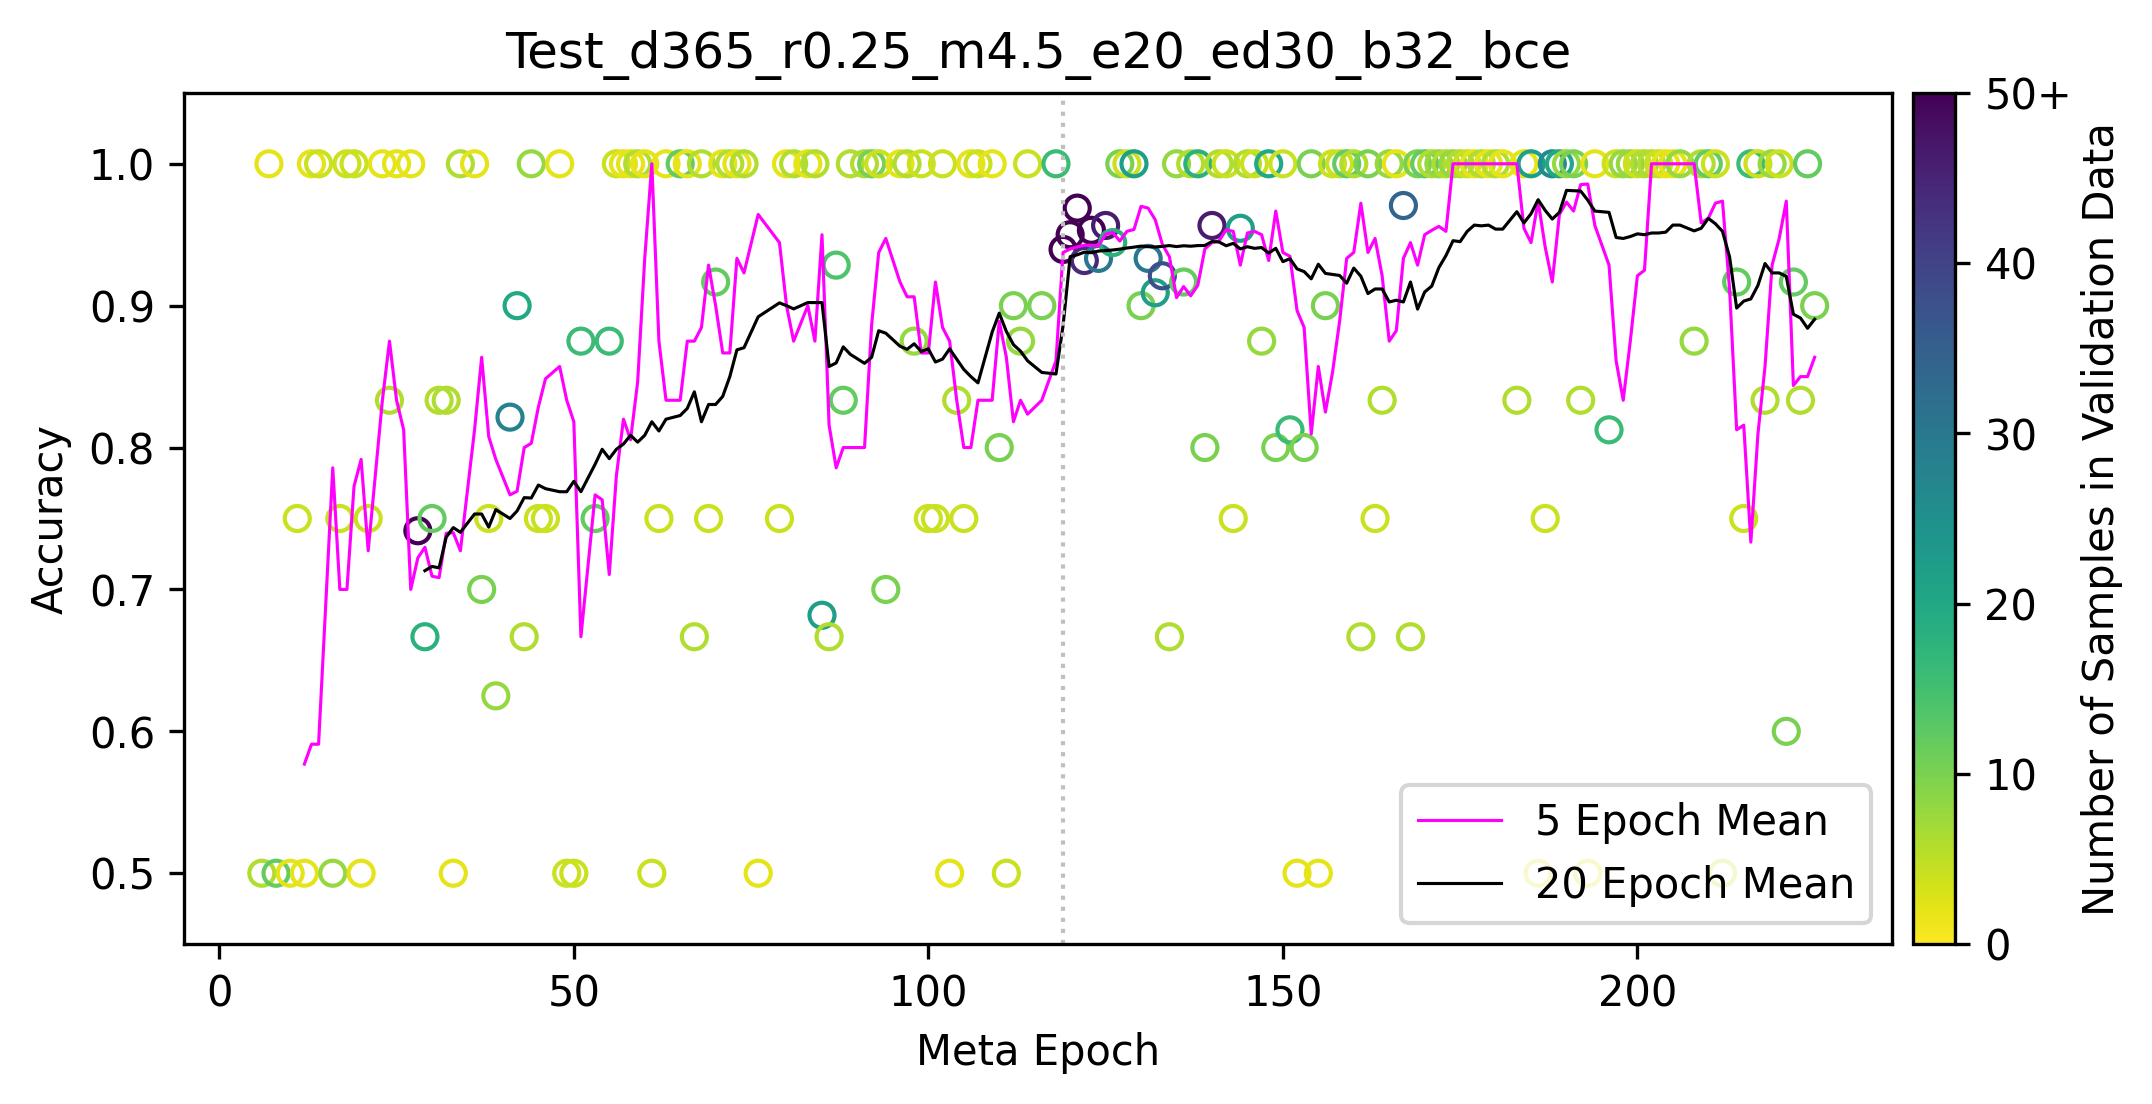

In [43]:
fig, ax = plt.subplots(1,1,figsize=(7,3.5), dpi=300)
plt.tight_layout(rect=[0.0125, 0.01, 0.93, 0.99])

def means(x, weights, N):
    return np.array([np.ma.average(x[i:i+N], weights=weights[i:i+N]) for i in range(len(x)-N)])

means05 = means(ncorr/ntotal, ntotal,  5)
means20 = means(ncorr/ntotal, ntotal, 20)


cmap = mpl.colormaps['viridis_r']
norm = mpl.colors.Normalize(vmin=0, vmax=50)


ax.scatter(epochs, ncorr/ntotal, edgecolor=cmap(norm(ntotal)), marker='o', facecolor='none')

#ax.scatter(epochs, ncorr/ntotal, s=7, alpha=0.5, label='Single Epochs')
ax.plot(epochs[ 5:], means05, label= '5 Epoch Mean', color='magenta', lw=0.75)
ax.plot(epochs[20:], means20, label='20 Epoch Mean', color='k', lw=0.75)

ax.axvline(epochs[np.argmax(ntotal)], ls=':', lw=1, color='silver')

ax.set_ylim([0.45, 1.05])
ax.set_xlabel('Meta Epoch')
ax.set_ylabel('Accuracy')
ax.legend(loc='lower right')

ax.set_title(run_name)

def CBPlacer(ax, top=False):
    x0 = ax.get_position().x1+0.01
    x1 = 0.02
    y0 = ax.get_position().y0
    y1 = ax.get_position().y1-y0
    return [x0, y0, x1, y1]


axc = fig.add_axes(CBPlacer(ax))
cb1 = mpl.colorbar.ColorbarBase(axc, cmap=cmap, norm=norm, orientation='vertical')
cb1.set_label('Number of Samples in Validation Data', labelpad=2)
cb1.set_ticks(np.arange(0, 51, 10))
cb1.set_ticklabels(['0','10','20','30','40','50+'])


plt.savefig('imgs_ftps/'+run_name+'.png')
plt.savefig('imgs_ftps/'+run_name+'.pdf')